In [1]:
# Sam Brown
# sam_brown@mines.edu
# July 17
# Goal: Explore the patterns of high and low tide events

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

df = pd.read_csv("/Users/sambrown04/Documents/SURF/Preproc_data/averages_events_2011-13.csv")
df_full = pd.read_csv("/Users/sambrown04/Documents/SURF/Preproc_data/10-18.csv")
df_full.head()

,tide_deriv,form_fac,time_since,slip_size_standardized,high_t_evt,start_time,sev_stds,pre-s_stds,tide_height,inter_form_Fac,A_diurn,A_semidiurn
0,0.024640,3.782138,NaN,-1.931350,1,2010-01-01 15:25:00,-0.270159,-0.831226,108.956127,NaN,NaN,NaN
1,-0.232954,3.782138,512.50,-2.792976,0,2010-01-01 23:58:00,-0.668066,-0.739235,-126.423818,3.878220,112.390988,28.980043
2,-0.087155,3.126144,1037.75,-0.793920,1,2010-01-02 17:15:00,-0.180573,0.594509,94.249899,3.003587,100.522043,33.467327
3,0.138536,2.571349,1382.75,-0.838199,1,2010-01-03 16:18:00,-0.209510,-0.773764,65.040870,2.356065,-88.364543,37.505133
4,-0.484872,2.571349,445.00,-1.435594,0,2010-01-03 23:43:00,-0.204831,-0.806752,-57.608298,2.632244,76.161191,28.933946


In [2]:
sequence = [1 if x == 1 else -1 for x in df_full['high_t_evt']]

y_values = np.cumsum(sequence)

# Include initial value at 0
y_values = np.insert(y_values, 0, 0)

# x-axis values
x_values = np.arange(len(y_values))

averaged_sl = y_values[-1] / x_values[-1]
print(averaged_sl)

0.36451048951048953


In [3]:
# Would like to find time period of the quickest increase Will use sliding window of 15 events, close to a months time
window_len = 50
changes = []
displacement = []
fast_interval = []
slow_interval = []
interval_displ = []
interval_disph = []
interval_disp = []

for i in range(0, len(y_values) - window_len, window_len):
    window = y_values[i:i+window_len]
    change = window[-1] - window[0]

    # Calaculate slope
    current_sl = change/window_len
    
    interval_disp.append((i+window_len, df_full['slip_size_standardized'].iloc[i:i+window_len].mean()))
    
    # If it is above the average save the time frame
    if current_sl > averaged_sl:
        fast_interval = list(set(fast_interval + list(range(i, i+window_len))))
        interval_disph.append(df_full['slip_size_standardized'].iloc[i:i+window_len].sum())
    else:
        slow_interval = list(set(slow_interval + list(range(i, i+window_len))))
        interval_displ.append(df_full['slip_size_standardized'].iloc[i:i+window_len].sum())
    
    changes.append((i, change))

    # Displacement for event
    displacement.append(df['total_delta'].iloc[i:i+window_len].sum())

# Min and max
max_val = max(changes, key=lambda x: x[1])
min_val = min(changes, key=lambda x: x[1])

# Most stable
stable_val = min(changes, key = lambda x: abs(x[1]))
zero_vals = [event for event in changes if event[1] == 0]

In [13]:
def group_consecutive(vals):
    ranges = []
    start = prev = vals[0]
    for val in vals[1:]:
        if val == prev + 1:
            prev = val
        else:
            ranges.append((start, prev + 1))  # +1 so axvspan covers full range
            start = prev = val
    ranges.append((start, prev + 1))
    return ranges

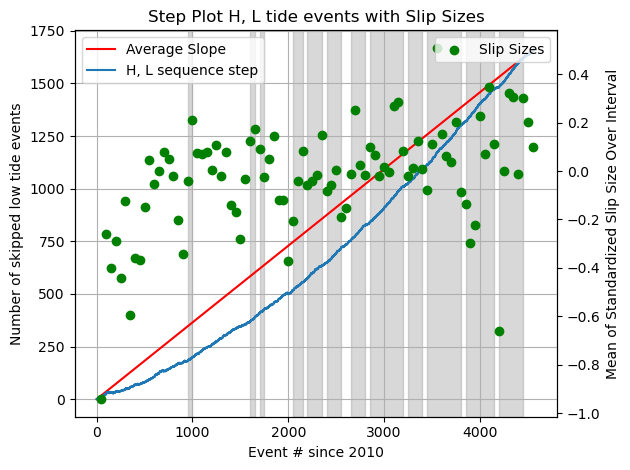

In [15]:
# Printing the average slope for events
shaded_ranges = group_consecutive(sorted(fast_interval))

m = averaged_sl
y = averaged_sl * x_values

fig, ax = plt.subplots()

for xmin, xmax in shaded_ranges:
    ax.axvspan(xmin, xmax, color='gray', alpha=0.3)

ax.plot(x_values, y, label='Average Slope', color='red')
ax.step(x_values, y_values, label='H, L sequence step', where='post')

ax.set_title("Step Plot H, L tide events with Slip Sizes")
ax.set_xlabel("Event # since 2010")
ax.set_ylabel("Number of skipped low tide events")
ax.grid(True)
ax.legend(loc="upper left")

ax1 = ax.twinx()
x_val, y_val = zip(*interval_disp)  # unpack slip size data
ax1.scatter(x_val, y_val, color='green', marker='o', label='Slip Sizes')

ax1.set_ylabel('Mean of Standardized Slip Size Over Interval')
ax1.legend(loc="upper right")

plt.tight_layout()
plt.show()

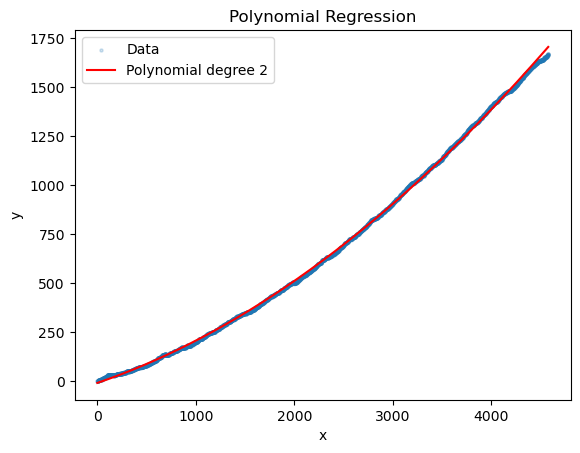

y = -9.380 + 0.17173 * x0 + 0.00004 * x0^2
r2: 0.9996549440149411


In [17]:
# Fit curve to this trend and interpret it
deg = 2

model = make_pipeline(PolynomialFeatures(deg), LinearRegression())

model = Pipeline([
    ("poly", PolynomialFeatures(degree=deg)),  
    ("linreg", LinearRegression())
])

model.fit(x_values.reshape(-1, 1), y_values)

x_fit = x_values.reshape(-1,1)
y_fit = model.predict(x_fit)

fig, ax = plt.subplots()

ax.scatter(x_values, y_values, label="Data", alpha=0.2, s=5)
ax.plot(x_fit, y_fit, color="red", label=f"Polynomial degree {deg}")

ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Polynomial Regression")

plt.show()

coefs = model.named_steps['linreg'].coef_
intercept = model.named_steps['linreg'].intercept_

poly = model.named_steps['poly']
powers = poly.get_feature_names_out()

# Print equation
terms = [f"{coef:.5f} * {term}" for coef, term in zip(coefs, powers)]
equation = f"{intercept:.3f} + " + " + ".join(terms[1:])  # skip the bias term
print("y =", equation)
print(f"r2: {r2_score(y_values, y_fit)}")

In [19]:
#Interpretation: 
# When there is a skipped low tide event, the value of y increases by one
# Ideas: Train model that predicts the slip size not by individual events but by total slip observed during events for month periods
# This could allow for this trend to be captured 

In [21]:
# Now we will explore changing our step plot to have more information (High low tide events is not sufficient)
# Slide will be proportional to slip size and tide height. 
ys = [0]
xs = []

def y_step(tide_h, slip_size):
    slip_shift = slip_size + 3.574789
    y_change = slip_shift * tide_h
    return y_change

for _, row in df_full.iterrows():
    step = (y_step(row['tide_height'], row['slip_size_standardized']))
    ys.append(ys[-1] + step)

xs = np.arange(len(ys))

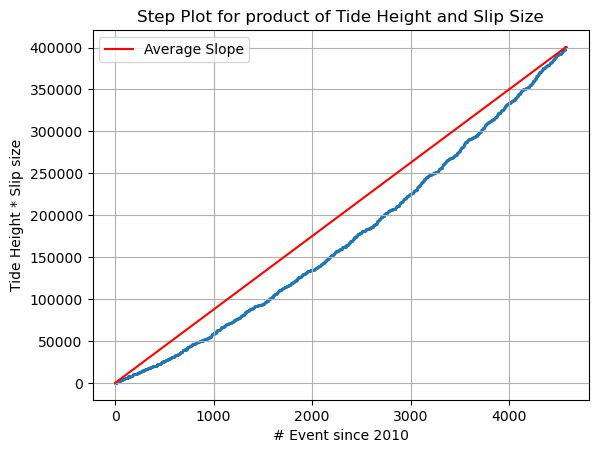

In [23]:
average_sl = ys[-1] / xs[-1]
yls = xs*average_sl

fig, ax = plt.subplots()

ax.scatter(xs, ys, s = .3)
ax.plot(xs,yls, color = 'red', label = 'Average Slope')
ax.set_xlabel('# Event since 2010')
ax.set_ylabel('Tide Height * Slip size')
ax.set_title("Step Plot for product of Tide Height and Slip Size")
ax.legend()
ax.grid(True)


In [25]:
# The product of tide height and slip size is increasing polynomially.

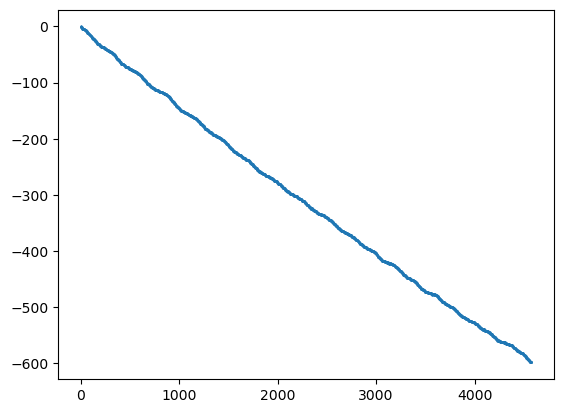

In [27]:
# Look at tide derivative for a step plot
ys_deriv = [0]
for _, row in df_full.iterrows():
    step = row['tide_deriv']
    ys_deriv.append(ys_deriv[-1] + step)

plt.scatter(xs, ys_deriv, s = .3)